In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.utils import shuffle

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.stem import WordNetLemmatizer
import contractions

import matplotlib. pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf

2023-03-08 16:05:46.990001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data = pd.read_json("datasets/dataset.json")
data.drop(['violation'], axis=1, inplace=True)


# data = shuffle(data)

df = data[:80000]

test =  data[80001:]# pd.read_json("datasets/test_data.json")

In [4]:
df.head()

,text,hasBadWords
55874,"All about lactation, milking and sucking on bi...",False
57274,tickle torture,True
46832,3076 Clip Store,False
18840,I'm Back Bitches,False
24724,<p>After breaking the faces of her slaves in t...,False


In [28]:
oversample = RandomOverSampler(sampling_strategy='minority')

In [30]:
X_over, y_over = oversample.fit_resample(df, df["hasBadWords"])

In [35]:
df["hasBadWords"].value_counts()

False    76967
True      3033
Name: hasBadWords, dtype: int64

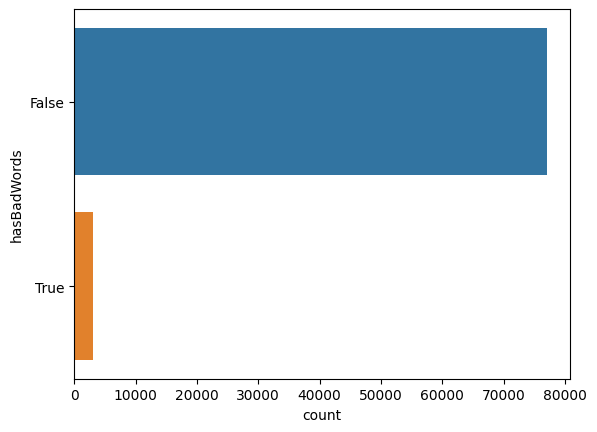

In [34]:
sns.countplot(y = df['hasBadWords']);

In [7]:
stop_word = set(stopwords.words("english"))

In [8]:
punt = punctuation.replace("!","").replace("?","")

In [9]:
def text_tokenize(text):
    tokenizer = word_tokenize(text, language='english', preserve_line=False)
    lemmatizer = WordNetLemmatizer()
    tokens = tokenizer #.tokenize(contractions.fix(text))
    
    pruned = []
    
    for token in tokens:
        if token not in punctuation and not token.startswith("http"):
            if token.startswith("@"):
                token = token.replace("@","")
                pruned.append(lemmatizer.lemmatize(token.lower()))

            else:
                
                pruned.append(lemmatizer.lemmatize(token.lower()))
            
    return pruned
clean_text = df["text"].apply(lambda x: text_tokenize(x))
clean_text.head()

55874    [all, about, lactation, milking, and, sucking,...
57274                                    [tickle, torture]
46832                                  [3076, clip, store]
18840                                 [i, 'm, back, bitch]
24724    [p, after, breaking, the, face, of, her, slave...
Name: text, dtype: object

In [10]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(clean_text, df["hasBadWords"], test_size=0.3, random_state=2023, stratify=df["hasBadWords"])
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((56000,), (24000,), (56000,), (24000,))

In [11]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
# Reshape column 
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

In [13]:
one_hot_encode = OneHotEncoder(sparse_output=False)

In [14]:
y_train = one_hot_encode.fit_transform(y_train)
y_test = one_hot_encode.transform(y_test)

In [15]:
X_train = X_train.to_list()
X_test = X_test.to_list()

tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_input_length = np.max([len(x) for x in X_train])

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding= "post", maxlen = max_input_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding= "post", maxlen = max_input_length)


# Import LSTM**

In [16]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout, Bidirectional, GRU,SimpleRNN,Embedding

from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

In [17]:
max_vocab = len(tokenizer.word_index) + 1
input_data = Input((max_input_length,), name= "input_layer")
embedding_output = Embedding(max_vocab, 100, mask_zero = True, name = "embedding_layer")(input_data)

2023-03-08 16:06:54.924881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=50, decay_rate=0.9, staircase=False)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.weight_decay(tf.float32)
    return lr

optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

lr_metric = get_lr_metric(optimizer)

model = Sequential()
model.add(Dense(64,input_shape = (8952,), activation = 'relu'))
model.add(Dropout(0.6))
model.add(Dense(100, activation='relu'))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(2,activation='tanh'))

# model.compile(loss='categorical_crossentropy', optimizer='adam')

model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                572992    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 100)               6500      
                                                                 
 dense_2 (Dense)             (None, 1024)              103424    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0

In [19]:
model.fit(X_train, y_train, batch_size = 512, epochs = 4, validation_data = (X_test, y_test))

Epoch 1/4
110/110 [==============================] - 17s 148ms/step - loss: nan - accuracy: 0.9592 - val_loss: nan - val_accuracy: 0.9621
Epoch 2/4
110/110 [==============================] - 13s 115ms/step - loss: nan - accuracy: 0.9621 - val_loss: nan - val_accuracy: 0.9621
Epoch 3/4
110/110 [==============================] - 13s 119ms/step - loss: nan - accuracy: 0.9621 - val_loss: nan - val_accuracy: 0.9621
Epoch 4/4
110/110 [==============================] - 13s 122ms/step - loss: nan - accuracy: 0.9621 - val_loss: nan - val_accuracy: 0.9621


In [20]:
# model.save('models/lstm.model')

In [21]:
test.head()

,text,hasBadWords
49314,5762 Clip Store,False
30659,"<table class=""table table-striped"">\r\n<tbody>...",False
32279,<p>A long title for some long balloons!</p>\r\...,False
34922,"INFLATABLE SUITS, RUBBER BONDAGE, RUBBER FETIS...",False
83704,<center><div class='top_html' align='center'><...,False


In [22]:
# normalize and toknize to test data
text = test["text"]
text = text.apply(lambda x : text_tokenize(x))
text = text.to_list()
text = tokenizer.texts_to_sequences(text)
text = tf.keras.preprocessing.sequence.pad_sequences(text, padding = "post", maxlen = max_input_length)

In [23]:
test.shape

(6438, 2)

In [24]:
# predictions 
pred = model.predict(text)
hasBadWords = one_hot_encode.inverse_transform(pred)
test["Prediction"] = hasBadWords

202/202 [==============================] - 1s 4ms/step


ValueError: Input contains NaN.

In [ ]:
test.head()

In [ ]:
accuracy = np.sum(test["hasBadWords"] == test["Prediction"]) / len(test)
print("accuracy = {}".format(accuracy))

In [ ]:
# Wrong prediction 
# (test[test["hasBadWords"] != test["Prediction"]])

In [ ]:
test.to_csv('datasets/test.csv')